# Field Phasing and Scaling (Autophase)

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Nicer plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Get field

In [2]:
from pmd_beamphysics import FieldMesh

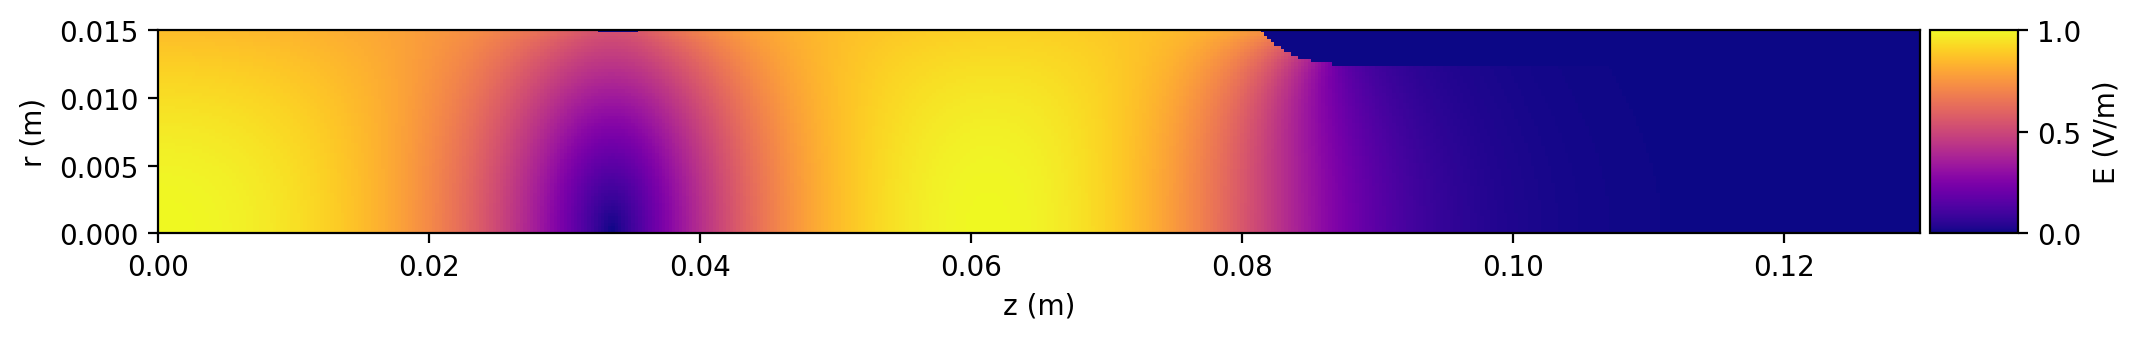

In [3]:
FM = FieldMesh('../data/rfgun.h5')
FM.plot(aspect='equal', figsize=(12,8))

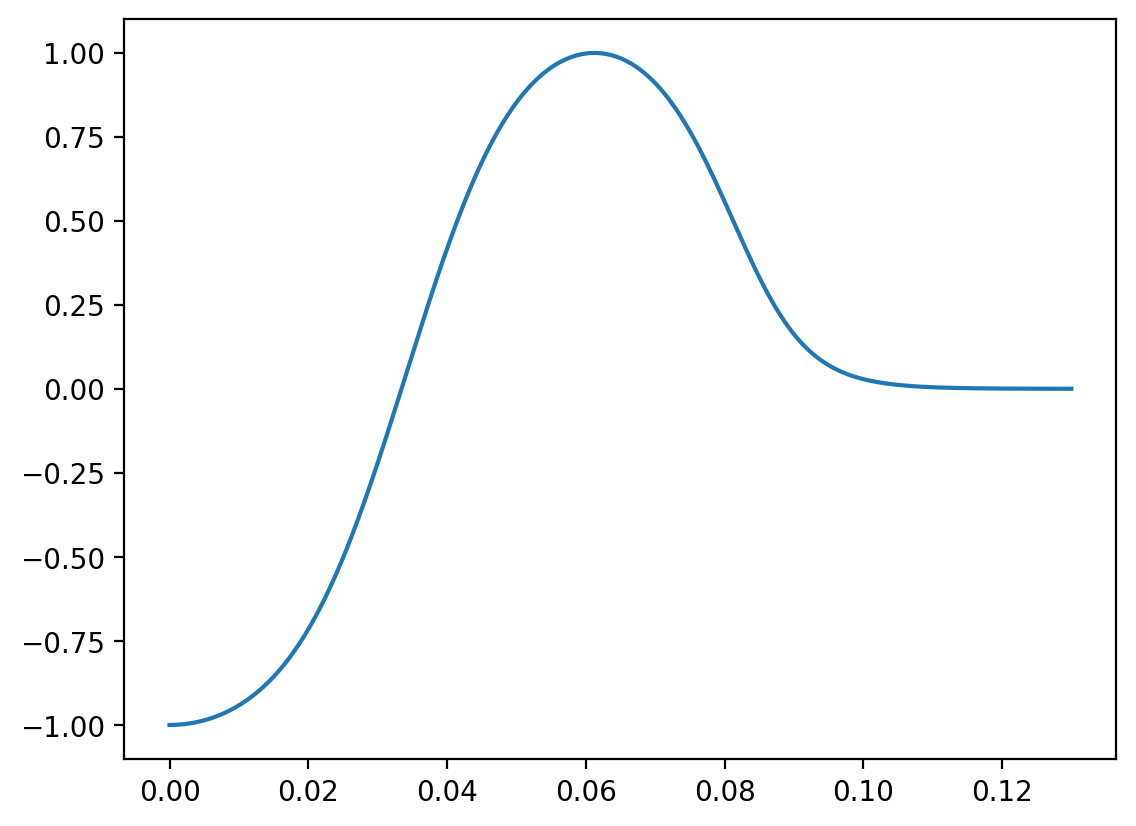

In [4]:
# On-axis field
z0 = FM.coord_vec('z')
Ez0 = FM.Ez[0,0,:]  # this is complex
plt.plot(z0, np.real(Ez0))

# v=c voltage and phase

In [5]:
from pmd_beamphysics.fields.analysis import accelerating_voltage_and_phase

In [6]:
?accelerating_voltage_and_phase

In [7]:
V0, phase0 = accelerating_voltage_and_phase(z0, -Ez0*120e6, FM.frequency)

V0, (phase0 * 180/np.pi) % 360

(5795904.446882587, 322.1355626180106)

# Tracking

Equations of motion:

$\frac{dz}{dt} = \frac{pc}{\sqrt{(pc)^2 + m^2 c^4)}} c$ 

$\frac{dp}{dt} = q E_z $

$E_z = \Re f(z) \exp(-i \omega t) $

In [8]:
from pmd_beamphysics.fields.analysis import track_field_1d
from pmd_beamphysics.units import mec2, c_light

In [9]:
?track_field_1d

In [10]:
Z = FM.coord_vec('z')
E = FM.Ez[0,0,:]*np.exp(1j*2*np.pi /360 * 0)*120e6 

# Final z (m) and pz (eV/c)
track_field_1d(Z, E, FM.frequency, pz0=0, t0=0)

(0.13000001229731462, 3896770.3798070885)

In [11]:
# Use debug mode to see the actual track
sol = track_field_1d(Z, E, FM.frequency, pz0=0, t0=0, debug=True, max_step=1/FM.frequency/100)

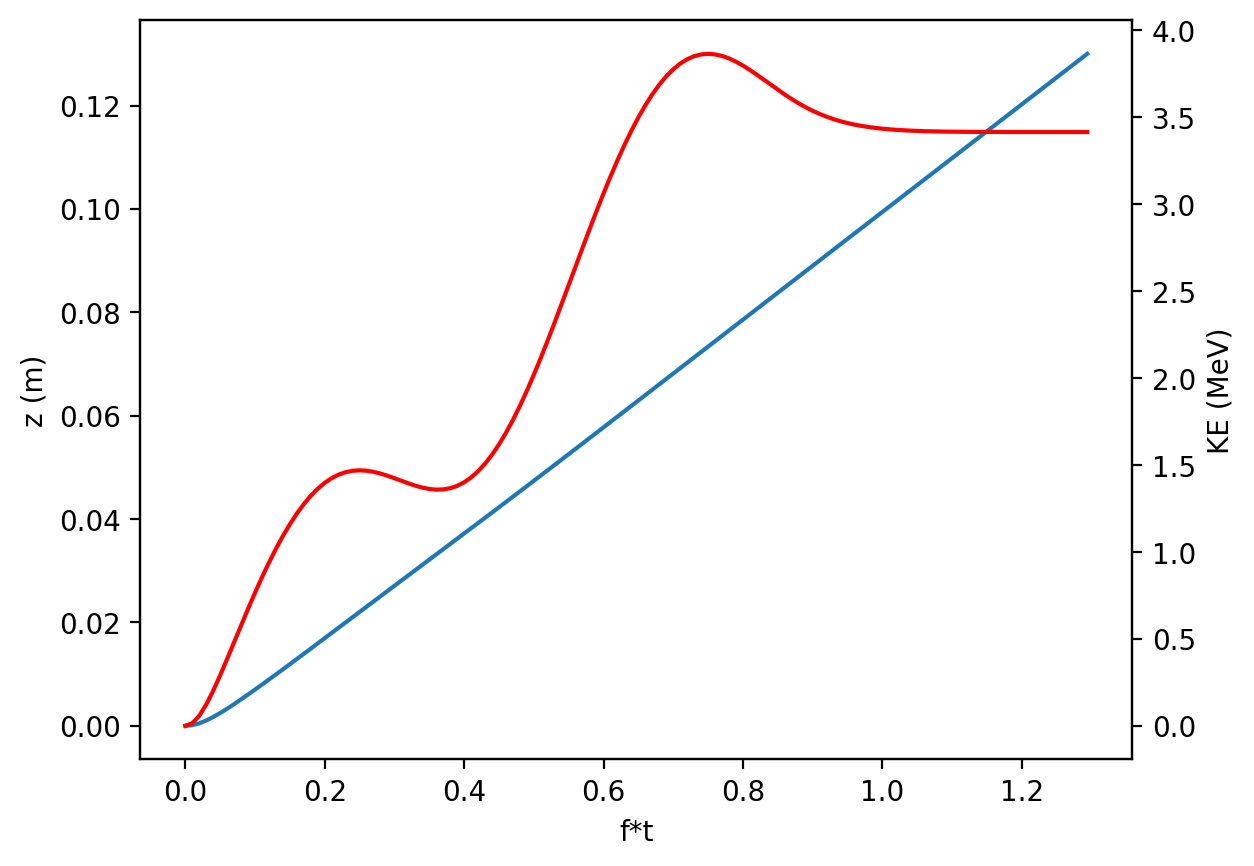

In [12]:
# Plot the track
fig, ax = plt.subplots()

ax2 = ax.twinx()

ax.set_xlabel('f*t')
ax.set_ylabel('z (m)')
ax2.set_ylabel('KE (MeV)')

ax.plot(sol.t*FM.frequency, sol.y[0])
ax2.plot(sol.t*FM.frequency, (np.hypot(sol.y[1], mec2)-mec2)/1e6, color='red')

# Autophase

In [13]:
from pmd_beamphysics.fields.analysis import autophase_field

In [14]:
phase_deg1, pz1 = autophase_field(FM, pz0=0, scale=120e6, verbose=True)
phase_deg1, pz1 

v=c voltage: 5795904.446882587 V, phase: -37.86443738198939 deg
    iterations: 18
    function calls: 23


(304.33482581605494, 6234145.795778023)

In [15]:
# Use debug mode to visualize. This returns the phasiing function
phase_f = autophase_field(FM, pz0=0, scale=120e6, debug=True)
phase_f(304.3348289439232)

6234145.795777999

Text(0, 0.5, 'pz (MeV/c)')

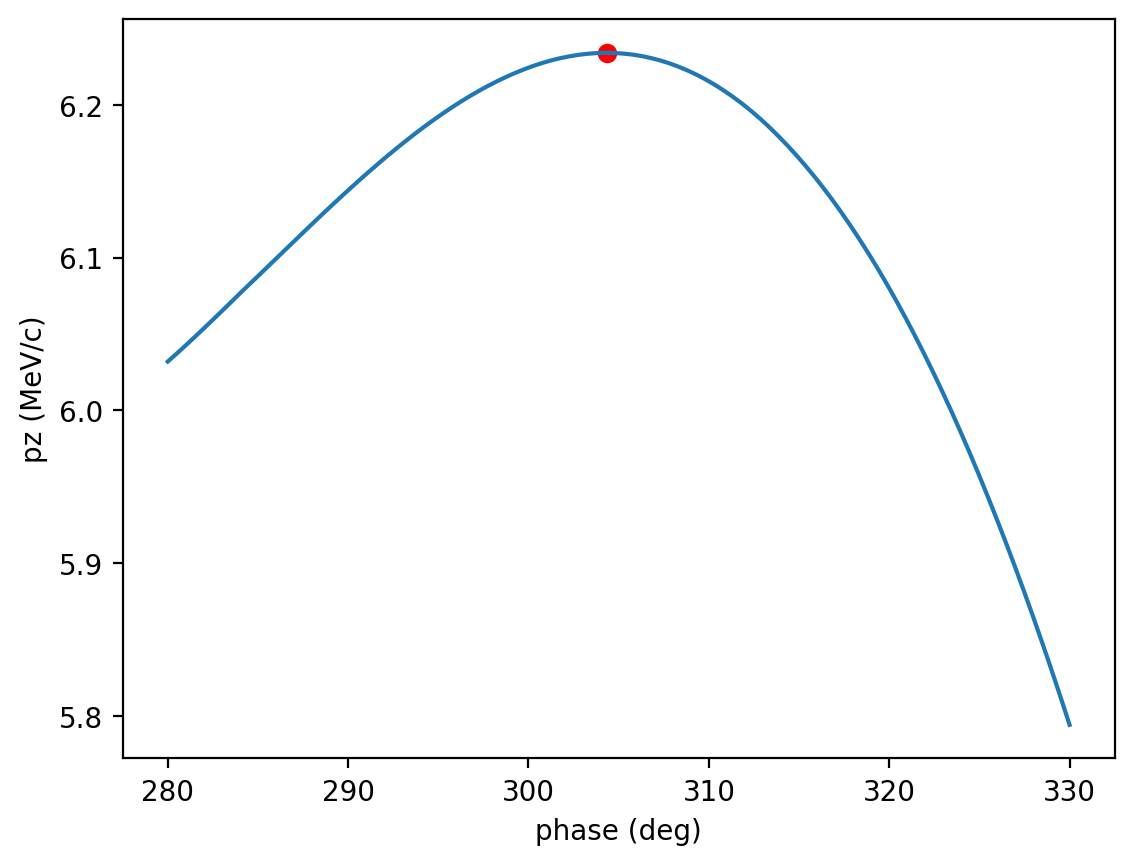

In [16]:
plist = np.linspace(280, 330, 100)
pzlist = np.array([phase_f(p) for p in plist])

plt.plot(plist, pzlist/1e6)
plt.scatter(phase_deg1, pz1/1e6, color='red')
plt.xlabel('phase (deg)')
plt.ylabel('pz (MeV/c)')

# Autophase and Scale

In [17]:
from pmd_beamphysics.fields.analysis import autophase_and_scale_field
?autophase_and_scale_field

In [18]:
phase_deg2, scale2 = autophase_and_scale_field(FM, 6e6, pz0=0, verbose=True)
phase_deg2, scale2

v=c voltage: 0.04829920372402156 V, phase: -37.86443738198939 deg
    Pass 1 delta energy: 6000000.288678044 at phase  304.9786262980494 deg
    Pass 2 delta energy: 5999999.999982606 at phase  305.14631149235083 deg


(305.14631149235083, 125273551.27124922)

In [19]:
# Use debug mode to visualize. This returns the phasing function
ps_f = autophase_and_scale_field(FM, 6e6, pz0=0, debug=True)
ps_f(phase_deg2, scale2)

5999999.999982606

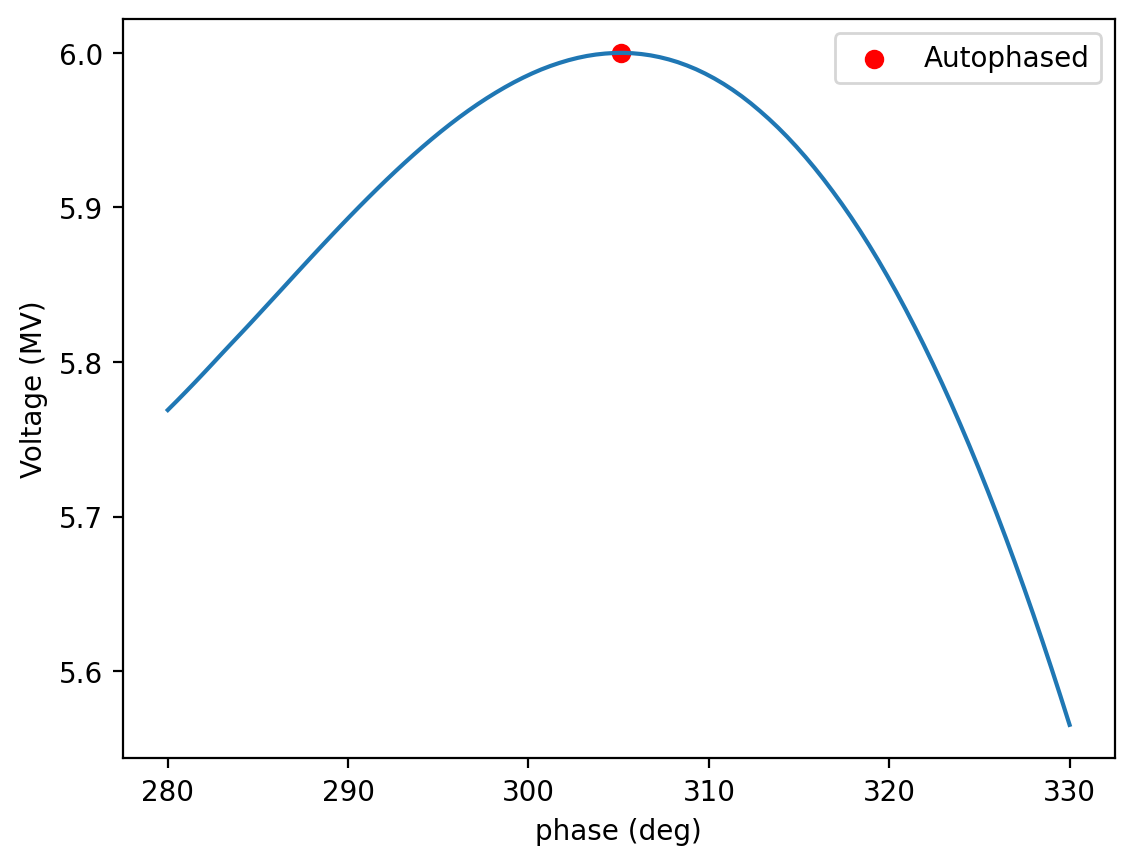

In [20]:
plist = np.linspace(280, 330, 100)
denergy = np.array([ps_f(p, scale2) for p in plist])

plt.plot(plist, denergy/1e6)
plt.scatter(phase_deg2, ps_f(phase_deg2, scale2)/1e6, color='red', label='Autophased')
plt.xlabel('phase (deg)')
plt.ylabel('Voltage (MV)')
plt.legend()